### 2D Diffusion with Spatial Dependence - Heterogenous Media
Numerical Method : *py-pde* solver. <br>
Code taken from [this tutorial](https://py-pde.readthedocs.io/en/latest/examples_gallery/pde_heterogeneous_diffusion.html). <br>
```
u_tt = D_x*u_x + D_y*u_y + D*(u_xx + u_yy)   on [-5,5] x [-5, 5] in the x-axis and [0,10] in time
```

Dirichlet Boundary Conditions : 
```
u=0
```

Diffusion Dependence :
```
 D = 2.22 + 2*tanh(x) 
```

InitialCondition : 
```
u(x,y,t=0) = 1
```


In [ ]:
! pip install py-pde  
import numpy as np
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, PlotTracker

# Expanded definition of the PDE
diffusivity = "2.22 + 2*tanh(x)"
term_1 = f"({diffusivity}) * laplace(c)"
term_2 = f"dot(gradient({diffusivity}), gradient(c))"
eq = PDE({"c": f"{term_1} + {term_2}"}, bc={"value": 0})

grid_length = 64
grid = CartesianGrid([[-5, 5], [-5,5]], [64, 64])  # generate grid
field = ScalarField(grid, 1)  # generate initial condition

storage = MemoryStorage()  # store intermediate information of the simulation
tracker = PlotTracker(interval=1.0)
res = eq.solve(field, 10, dt=1e-3, tracker=[tracker, storage.tracker(0.1)])  # solve the PDE


x = np.linspace(-5, 5, 64)
y = np.linspace(-5, 5, 64)
t = np.linspace(0, 10, 101)
D = 2.22 + 2*np.tanh(x)
u_sol = np.asarray(storage.data)

Diffusion = lambda x: 2.22 + 2*np.tanh(x)

Output()

In [ ]:
import os
import time
from tqdm import tqdm 
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
%matplotlib inline


!pip install pyDOE
from pyDOE import lhs
import torch
import torch.nn as nn

# %
default_device = "cuda" if torch.cuda.is_available() else "cpu"

dtype=torch.float32
torch.set_default_dtype(dtype)

def torch_tensor_grad(x, device):
    if device == 'cuda':
        x = torch.cuda.FloatTensor(x)
    else:
        x = torch.FloatTensor(x)
    x.requires_grad = True
    return x 

def torch_tensor_nograd(x, device):
    if device == 'cuda':
        x = torch.cuda.FloatTensor(x)
    else:
        x = torch.FloatTensor(x)
    x.requires_grad = False
    return x 


In [ ]:
# Setting the random seed. 
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
#Setting up a Resnet as the PINN. 
class Resnet(nn.Module):
    def __init__(self, in_features, out_features, num_neurons, activation=torch.sin):
        super(Resnet, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.num_neurons = num_neurons
        
        self.act_func = activation
        
        self.block1_layer1 = nn.Linear(self.in_features, self.num_neurons)
        self.block1_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        self.block1 = [self.block1_layer1, self.block1_layer2]
        
        self.block2_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        self.block2_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        self.block2 = [self.block2_layer1, self.block2_layer2]
        
        # self.block3_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        # self.block3_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        # self.block3 = [self.block3_layer1, self.block3_layer2]
        
        # self.block4_layer1 = nn.Linear(self.in_features + self.num_neurons, self.num_neurons)
        # self.block4_layer2 = nn.Linear(self.num_neurons, self.num_neurons)
        # self.block4 = [self.block4_layer1, self.block4_layer2]
        
        self.layer_after_block = nn.Linear(self.num_neurons + self.in_features, self.num_neurons)
        self.layer_output = nn.Linear(self.num_neurons, self.out_features)
        
        
    def forward(self, x):
        
        x_temp = x
        
        for dense in self.block1:
            x_temp = self.act_func(dense(x_temp))
        x_temp = torch.cat([x_temp, x], dim=-1)
        
        for dense in self.block2:
            x_temp = self.act_func(dense(x_temp))
        x_temp = torch.cat([x_temp, x], dim=-1)
        
        # for dense in self.block3:
        #    x_temp = self.act_func(dense(x_temp))           
        # x_temp = torch.cat([x_temp, x], dim=-1)
        
        # for dense in self.block4:
        #    x_temp = self.act_func(dense(x_temp))
        # x_temp = torch.cat([x_temp, x], dim=-1)
        
        x_temp = self.act_func(self.layer_after_block(x_temp))
        x_temp = self.layer_output(x_temp)
        return x_temp

#Setting up a derivative function that goes through the graph and calculates via chain rule the derivative of u wrt x 
deriv = lambda u, x: torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]


In [ ]:
#Setting up an instance of the Resnet with the needed architecture. 
npde_net = Resnet(3, 1, 100)
npde_net = npde_net.to(default_device)


In [ ]:
! pip install pyDOE
from pyDOE import lhs

#Specifying the Domain of Interest. 
x_range = [-5.0, 5.0]
y_range = [-5.0, 5.0]
t_range = [0.0, 10.0]
Diffusion = lambda x: 2.22 + 2*torch.tanh(x)

lb = np.asarray([x_range[0], y_range[0], t_range[0]])
ub = np.asarray([x_range[1], y_range[1], t_range[1]])

def LHS_Sampling(N):
    return lb + (ub-lb)*lhs(3, N)


In [ ]:
#Domain Loss Function - measuring the deviation from the PDE functional. 

def pde(X):

    x = X[:, 0:1]
    y = X[:, 1:2]
    t = X[:, 2:3]

    u = npde_net(torch.cat([x,y,t],1))

    u_x = deriv(u, x)
    u_xx = deriv(u_x, x)

    u_y = deriv(u, y)
    u_yy = deriv(u_y, y)

    u_t = deriv(u, t)

    D = Diffusion(x)
    D_x = deriv(D, x)

    
    pde_loss = u_t - D_x*u_x - D*(u_xx + u_yy)

    return pde_loss.pow(2).mean()


#Boundary Loss Function - measuring the deviation from boundary conditions for f(x_lim, y_lim, t)
def boundary(X):

    u = npde_net(X)
    bc_loss = u - 0 

    return bc_loss.pow(2).mean()


#Reconstruction Loss Function - measuring the deviation fromt the actual output. Used to calculate the initial loss
def reconstruction(X, Y):
    u = npde_net(X)
    recon_loss = u-Y
    return recon_loss.pow(2).mean()


In [ ]:
#Normalisation Strategies
def min_max_norm(x):
    return 2*(x-np.min(x))/(np.max(x)-np.min(x)) - 1

def z_score(x):
    return (x-np.mean(x)) / np.std(x)

def identity(x):
  return x


In [ ]:
#Samples taken from each region for optimisation purposes. 
N_i = 1000
N_b = 1000
N_f = 50000

In [ ]:
u = np.asarray(u_sol)
X, Y = np.meshgrid(x, y)
XY_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
T_star = np.expand_dims(np.repeat(t, len(XY_star)), 1)
X_star_tiled = np.tile(XY_star, (len(t), 1))

X_star = np.hstack((X_star_tiled, T_star))
u_star = np.expand_dims(u.flatten(),1)


In [ ]:
# Data for Initial Input 

X_IC = np.hstack((XY_star, np.zeros(len(XY_star)).reshape(len(XY_star), 1)))
u_IC = u[0].flatten()
u_IC = np.expand_dims(u_IC, 1)

idx = np.random.choice(X_IC.shape[0], N_i, replace=False) 
X_i = X_IC[idx]
u_i = u_IC[idx]

In [ ]:
# Data for Boundary Input

X_left = LHS_Sampling(N_b)
X_left[:,0:1] = x_range[0]

X_right = LHS_Sampling(N_b)
X_right[:,0:1] = x_range[1]

X_bottom = LHS_Sampling(N_b)
X_bottom[:,1:2] = y_range[0]

X_top = LHS_Sampling(N_b)
X_top[:,1:2] = y_range[1]

X_b = np.vstack((X_right, X_top, X_left, X_bottom))
np.random.shuffle(X_b) 

In [ ]:
#Data for Domain Input
X_f = LHS_Sampling(N_f)


In [ ]:
#Converting to tensors 

X_i = torch_tensor_grad(X_i)
Y_i = torch_tensor_nograd(u_i)
X_b = torch_tensor_grad(X_b)
X_f = torch_tensor_grad(X_f)

It: 1, Init: 1.077e+00, Bound: 4.710e-02, Domain: 2.182e-03
It: 2, Init: 9.340e-01, Bound: 1.027e-02, Domain: 1.469e-03
It: 3, Init: 7.931e-01, Bound: 4.608e-03, Domain: 1.451e-03
It: 4, Init: 6.522e-01, Bound: 2.019e-02, Domain: 2.048e-03
It: 5, Init: 5.117e-01, Bound: 4.351e-02, Domain: 3.207e-03
It: 6, Init: 3.750e-01, Bound: 6.355e-02, Domain: 4.981e-03
It: 7, Init: 2.499e-01, Bound: 7.670e-02, Domain: 7.585e-03
It: 8, Init: 1.488e-01, Bound: 8.465e-02, Domain: 1.142e-02
It: 9, Init: 8.516e-02, Bound: 9.120e-02, Domain: 1.700e-02
It: 10, Init: 6.333e-02, Bound: 1.002e-01, Domain: 2.455e-02
It: 11, Init: 6.850e-02, Bound: 1.125e-01, Domain: 3.242e-02
It: 12, Init: 7.432e-02, Bound: 1.198e-01, Domain: 3.687e-02
It: 13, Init: 6.714e-02, Bound: 1.130e-01, Domain: 3.604e-02
It: 14, Init: 5.246e-02, Bound: 9.539e-02, Domain: 3.128e-02
It: 15, Init: 4.047e-02, Bound: 7.598e-02, Domain: 2.506e-02
It: 16, Init: 3.635e-02, Bound: 6.206e-02, Domain: 1.941e-02
It: 17, Init: 3.966e-02, Bound: 5

Text(0, 0.5, 'L2 Error')

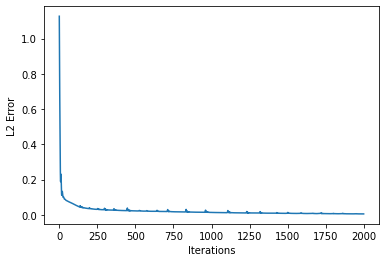

In [ ]:
#Training Loop
optimizer = torch.optim.Adam(npde_net.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.9)

it=0
epochs = 2000
loss_list = []

start_time = time.time()
while it < epochs :
    optimizer.zero_grad()

    initial_loss = reconstruction(X_i, Y_i) 
    boundary_loss = boundary(X_b)
    domain_loss = pde(X_f)

    loss = initial_loss + boundary_loss + domain_loss   
    loss_list.append(loss.item())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    it += 1

    print('It: %d, Init: %.3e, Bound: %.3e, Domain: %.3e' % (it, initial_loss.item(), boundary_loss.item(), domain_loss.item()))


train_time = time.time() - start_time
plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('L2 Error')

In [ ]:
#Getting the trained output. 
if default_device == 'cpu':
    with torch.no_grad():
        u_pred = npde_net(torch_tensor_grad(X_star)).detach().numpy()

else : 
    with torch.no_grad():
        u_pred = npde_net(torch_tensor_grad(X_star)).cpu().detach().numpy()
        
l2_error = np.mean((u_star - u_pred)**2)

u_pred = u_pred.reshape(len(u_sol), grid_length, grid_length)


In [ ]:
print('Training Time: %d seconds, L2 Error: %.3e' % (train_time, l2_error))


Training Time: 321 seconds, L2 Error: 7.382e-02


In [ ]:
!pip install celluloid
from celluloid import Camera
from IPython.display import HTML

extent = [lb[0], ub[0], lb[1], ub[1]]

def animate(data, name):
  fig = plt.figure()
  camera = Camera(fig)
  for ii in range(len(data)):
      plt.imshow(data[ii], extent=extent)
      plt.xlabel('x')
      plt.ylabel('y')
      plt.title(name)
      camera.snap()
  animation = camera.animate()

  return animation



def animate_flip(data, name):
  fig = plt.figure()
  camera = Camera(fig)
  for ii in range(len(data)):
      plt.imshow(np.flip(data[ii].T, 0), extent=extent)
      plt.xlabel('x')
      plt.ylabel('y')
      plt.title(name)
      camera.snap()
  animation = camera.animate()

  return animation


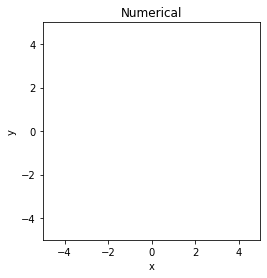

In [ ]:
animation = animate_flip(u_sol, 'Numerical')
HTML(animation.to_html5_video())

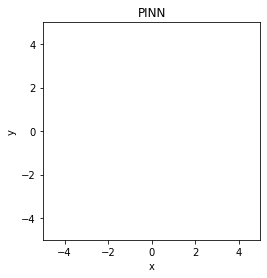

In [ ]:
animation = animate(u_pred, 'PINN')
HTML(animation.to_html5_video())

In [ ]:
from matplotlib import cm
from matplotlib import animation

def animation_plot(name, data):
    wave_name = name
    u_field = data
    xx, yy = np.meshgrid(x,y)


    def update_plot(frame_number, u_field, plot):
        plot[0].remove()
        plot[0] = ax.plot_surface(xx, yy, u_field[frame_number], cmap=cm.coolwarm, linewidth=2, antialiased=False)
        
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    plot = [ax.plot_surface(xx, yy, u_field[0], cmap=cm.coolwarm, linewidth=2, antialiased=False)]
    # ax.set_xlim3d(-1.0, 1.0)
    # ax.set_ylim3d(-1.0, 1.0)
    ax.set_zlim3d(-0.15, 1.15)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("U")
    ax.set_title(wave_name)

    # ax.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
    # ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])

    #plt.tight_layout()
    # ax.view_init(elev=30., azim=-110)


    fps = 50 # frame per sec
    frn = len(u_field) # frame number of the animation

    anim = animation.FuncAnimation(fig, update_plot, frn, fargs=(u_field, plot), interval=1000/fps)
    return anim

In [ ]:
# animation = animation_plot('Numerical', u_sol)
# HTML(animation.to_html5_video())


In [ ]:
# animation = animation_plot('PINN', u_pred)
# HTML(animation.to_html5_video())